In [124]:
import os
import sys
import subprocess

REPETITIONS = 3
RESOLUTIONS = ['144', '480', '720', '1080']
ARGS = ['images/video_supercropped.mp4', 'images/video_supercropped_edge.mp4', '3', '6', '0.5', '-1']
bins_veri = ['dog', 'dog_flag', 'dog_optimized', 'dog_parallel', 'dog_gpu', 'dog_gpu_pair']

FRAMES_PER_VIDEO = 3

print("Usage: python stats.py <repetitions> <input> <output> <sigma1> <sigma2> <threshold> <max_threads> <bin1> <bin2> ...")


Usage: python stats.py <repetitions> <input> <output> <sigma1> <sigma2> <threshold> <max_threads> <bin1> <bin2> ...


In [32]:

def get_stats(bin_path, threads = -1):
    # get the output of the executable
    try:
        # with args ARGS
        script_dir = '/home/taulant/CA_Project'
        bin_path = os.path.join(script_dir, bin_path)
        ARGS[0] = os.path.join(script_dir, ARGS[0])
        ARGS[1] = os.path.join(script_dir, ARGS[1])
        ARGS[-1] = str(threads)
# Connect via SSH and execute the script
        ssh_command = f"ssh taulant@192.168.92.41 '{bin_path} {' '.join(ARGS)}'"
        try:
            # print(f"Executing {ssh_command}")
            output = subprocess.check_output(ssh_command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            print(f"Error executing {bin_path} via SSH: {e.output.decode()}")
            return None, None, None, None, None
    except subprocess.CalledProcessError as e:
        print(f"Error executing {bin_path}: {e.output.decode()}")
        return None, None, None, None, None
    
    # decode the output
    output = output.decode()
    # parse the output
    lines = output.split('\n')

    cumulative_time = lines[-2].split('\t')



    return cumulative_time



In [98]:
results

{'dog': {'144': {'means': {'read': 0.0005473333333333334,
    'grayscale': 3.4666666666666665e-05,
    'dog': 0.06833144444444443,
    'writer': 0.0002458888888888889,
    'total': 0.06915944444444445},
   'variances': {'read': 2.2155555555560091e-10,
    'grayscale': 8.466666666666672e-11,
    'dog': 1.043312839516592e-07,
    'writer': 3.3358024691349444e-11,
    'total': 1.1483039506148756e-07},
   'std_deviation': {'read': 1.4884742374512262e-05,
    'grayscale': 9.201449161228177e-06,
    'dog': 0.00032300353550953465,
    'writer': 5.7756406303846025e-06,
    'total': 0.0003388663380471533}},
  '480': {'means': {'read': 0.002067777777777778,
    'grayscale': 0.0009364444444444445,
    'dog': 0.7616160000000001,
    'writer': 0.0017333333333333333,
    'total': 0.7663535555555555},
   'variances': {'read': 8.360246913569616e-10,
    'grayscale': 9.40987654322022e-11,
    'dog': 4.569841999825365e-06,
    'writer': 7.935555555559554e-10,
    'total': 4.7005186913177495e-06},
   'st

In [125]:
# stats for all scripts
results = {}

for bin_path in bins_veri:
    results[bin_path] = {}
    for resolution in RESOLUTIONS:
        ARGS[0] = f'images/video_supercropped_{resolution}.mp4'
        ARGS[1] = f'images/video_supercropped_edge_{resolution}.mp4'
        print(f"Running {bin_path}...")
        stat_sums = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}
        stat_squares = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}

        for i in range(REPETITIONS):
            read, grayscale, dog, writer, total = get_stats(bin_path)
            if total:
                stat_sums['read'] += float(read)
                stat_sums['grayscale'] += float(grayscale)
                stat_sums['dog'] += float(dog)
                stat_sums['writer'] += float(writer)
                stat_sums['total'] += float(total)

                stat_squares['read'] += float(read) ** 2
                stat_squares['grayscale'] += float(grayscale) ** 2
                stat_squares['dog'] += float(dog) ** 2
                stat_squares['writer'] += float(writer) ** 2
                stat_squares['total'] += float(total) ** 2

                print(f"Iteration {i + 1} for {bin_path}: read: {read}, grayscale: {grayscale}, dog: {dog}, writer: {writer}, total: {total}")

        variances = {
            stat: ((stat_squares[stat] / REPETITIONS) - (stat_sums[stat] / REPETITIONS) ** 2 )
            for stat in stat_sums
        }
        std_deviation = {
            stat: variances[stat] ** 0.5 / FRAMES_PER_VIDEO
            for stat in variances
        }
        means = {
            stat: stat_sums[stat] / REPETITIONS / FRAMES_PER_VIDEO
            for stat in stat_sums
        }

        

        results[bin_path][resolution] ={
            'means': means,
            'variances': variances,
            'std_deviation': std_deviation
        }
        
        print(f"Results for {bin_path}:")
        for stat in means:
            print(f"  {stat}: {means[stat]} ± {std_deviation[stat]} (variance: {variances[stat]})")

Running dog...
Iteration 1 for dog: read: 0.001554, grayscale: 0.000098, dog: 0.204525, writer: 0.000730, total: 0.206908
Iteration 2 for dog: read: 0.001683, grayscale: 0.000086, dog: 0.207605, writer: 0.000754, total: 0.210129
Iteration 3 for dog: read: 0.001771, grayscale: 0.000084, dog: 0.203556, writer: 0.000722, total: 0.206134
Results for dog:
  read: 0.0005564444444444445 ± 2.9705135275375023e-05 (variance: 7.941555555554967e-09)
  grayscale: 2.977777777777778e-05 ± 2.060804110110101e-06 (variance: 3.822222222222016e-11)
  dog: 0.06840955555555554 ± 0.000575419996906871 (variance: 2.9799735555627316e-06)
  writer: 0.00024511111111111115 ± 4.53246178985792e-06 (variance: 1.8488888888869855e-10)
  total: 0.06924122222222222 ± 0.0005766435662255985 (variance: 2.992660222224386e-06)
Running dog...
Iteration 1 for dog: read: 0.006318, grayscale: 0.002757, dog: 2.299608, writer: 0.005157, total: 2.313840
Iteration 2 for dog: read: 0.006189, grayscale: 0.002812, dog: 2.274264, writer:

In [ ]:
# NON ESEGUIRE PIU'
# Update results by dividing mean times and variances by FRAMES_PER_VIDEO
for bin_key, resolutions in results.items():
    for resolution_key, stats in resolutions.items():
        stats['means'] = {key: value / FRAMES_PER_VIDEO for key, value in stats['means'].items()}
        stats['variances'] = {key: value / FRAMES_PER_VIDEO**2 for key, value in stats['variances'].items()}
        stats['std_deviation'] = {key: value / FRAMES_PER_VIDEO for key, value in stats['std_deviation'].items()}


{'read': [0.0005564444444444445, 0.002097777777777778, 0.004047222222222222, 0.009398777777777778], 'grayscale': [2.977777777777778e-05, 0.000922111111111111, 0.001048888888888889, 0.001451222222222222], 'dog': [0.06840955555555554, 0.763321888888889, 1.7088764444444446, 3.832319111111111], 'writer': [0.00024511111111111115, 0.001725111111111111, 0.0024417777777777775, 0.004348222222222223]}
{'read': [2.9705135275375023e-05, 2.5705358042610373e-05, 2.5741353576541617e-05, 0.0006071606251160988], 'grayscale': [2.060804110110101e-06, 1.1373566929125857e-05, 1.4016744836176509e-05, 9.829409135408944e-06], 'dog': [0.000575419996906871, 0.0037328990256552063, 0.0008560916497536167, 0.0017500158811685352], 'writer': [4.53246178985792e-06, 1.3889333326239666e-05, 6.504091779529553e-05, 7.362081697018817e-05]}


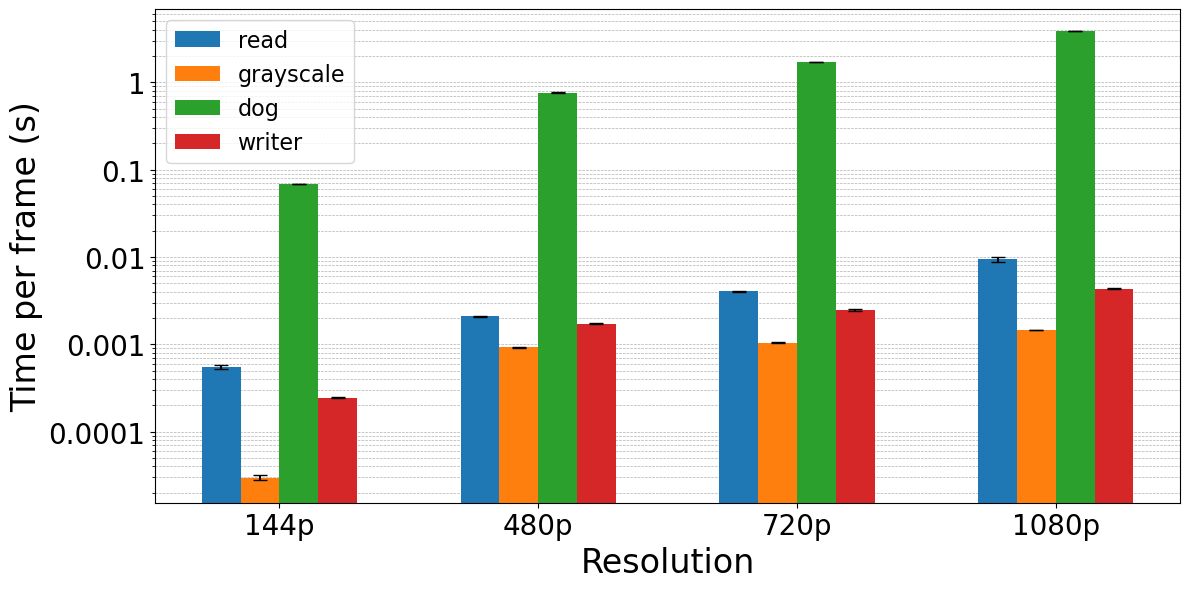

In [126]:
#single bin 
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())
categories = ['read', 'grayscale', 'dog', 'writer', 'total'][:-1]  # Exclude 'total' for individual bar plots


# Reorder bins for plotting
bins = ['dog', 'dog_optimized', 'dog_parallel', 'dog_gpu']
bins = ['dog_gpu']

bins = RESOLUTIONS

single_bin_results = results['dog']

# Prepare data for means and confidence intervals
means = {category: [single_bin_results[bin]['means'][category] for bin in bins] for category in categories}
std_devs = {category: [single_bin_results[bin]['std_deviation'][category] for bin in bins] for category in categories}

print(means)
print(std_devs)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each category
for i, category in enumerate(categories):
    ax.bar(x + i * width, means[category], width, label=category, yerr=std_devs[category], capsize=5)

# Add labels, title, and legend
#ax.set_xlabel('Bins')
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
# ax.set_title('Execution Time')
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in bins], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))


ax.legend(fontsize=16)
# Export the plot as an SVG
#fig.savefig('/tmp/execution_time_plot_log.svg', format='svg')
# Automatically adjust the borders to prevent the image from being cut off
plt.tight_layout(pad=3.0)
fig.savefig('/tmp/execution_time_plot_log.svg', format='svg')
# Show plot
plt.tight_layout()
plt.show()



{'dog': [0.06840955555555554, 0.763321888888889, 1.7088764444444446, 3.832319111111111]}
{'dog': [0.000575419996906871, 0.0037328990256552063, 0.0008560916497536167, 0.0017500158811685352]}
Plot exported as execution_time_plot.svg


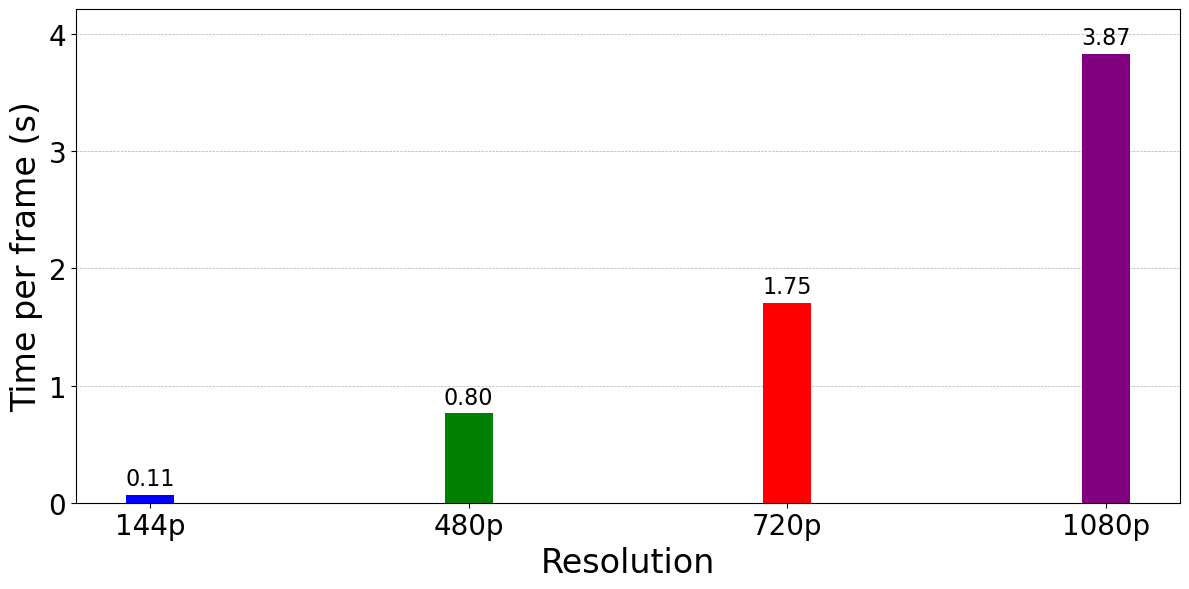

In [138]:
#single bin 
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())
categories = ['dog']  # Exclude 'total' for individual bar plots


# Reorder bins for plotting
bins = ['dog', 'dog_optimized', 'dog_parallel', 'dog_gpu']
bins = ['dog_gpu']

bins = RESOLUTIONS

single_bin_results = results['dog']

# Prepare data for means and confidence intervals
means = {category: [single_bin_results[bin]['means'][category] for bin in bins] for category in categories}
std_devs = {category: [single_bin_results[bin]['std_deviation'][category] for bin in bins] for category in categories}

print(means)
print(std_devs)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each category
colors = ['blue', 'green', 'red', 'purple']  # Define a list of colors for each bin
for i, category in enumerate(categories):
    bars = ax.bar(x + i * width, means[category], width, label=category, color=colors[:len(bins)])
    for bar in bars:
        height = bar.get_height()+0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=16)

# Add labels, title, and legend
#ax.set_xlabel('Bins')
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
# ax.set_title('Execution Time')
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in bins], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
#ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_ylim(top=max(height * 1.1 for height in means['dog']))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

plt.tight_layout(pad=3.0)

fig.savefig('/tmp/execution_time_plot_lineare.svg', format='svg')
print("Plot exported as execution_time_plot.svg")

# Show plot
plt.tight_layout()
plt.show()



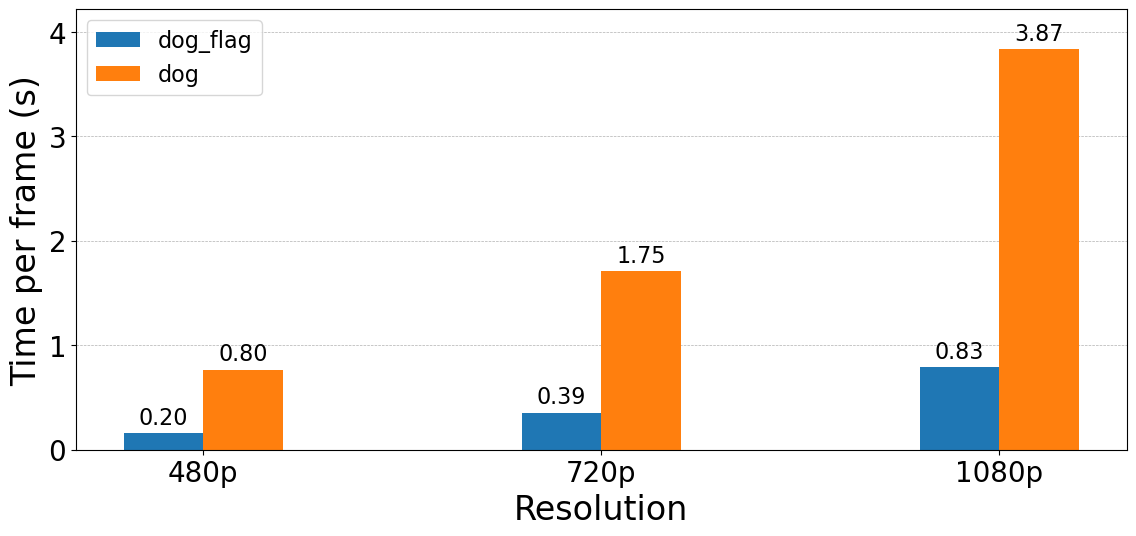

In [137]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())

bins = ['dog_flag', 'dog']
res = RESOLUTIONS[1:]

# Prepare data for means and confidence intervals for each bin and resolution
means = {bin_key: [results[bin_key][resolution]['means']['dog'] for resolution in res] for bin_key in bins}
std_devs = {bin_key: [results[bin_key][resolution]['std_deviation']['dog'] for resolution in res] for bin_key in bins}



# Plotting
x = np.arange(len(res))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each bin
for i, bin_key in enumerate(bins):
    bars = ax.bar(x + i * width, means[bin_key], width, label=bin_key)
    for bar in bars:
        height = bar.get_height()+0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=16)

# Add labels, title, and legend
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
ax.set_xticks(x + width * (len(bins) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in res], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=16)
ax.set_ylim(bottom=0, top=max(height * 1.1 for height in means['dog']))
# Automatically adjust the borders to prevent the image from being cut off
plt.tight_layout(pad=3.0)

# Show plot
plt.show()



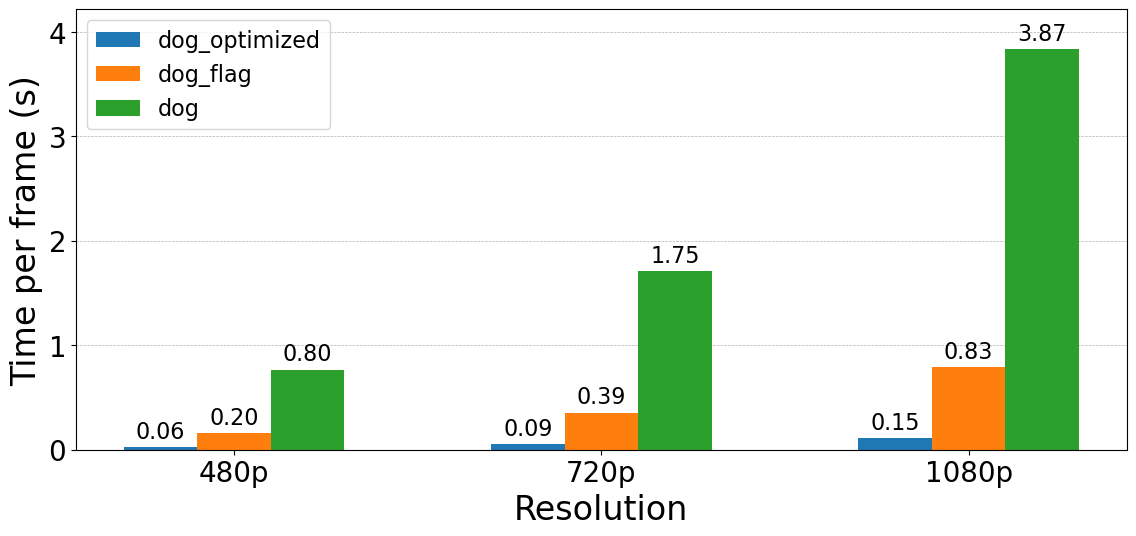

In [147]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())

bins = ['dog_optimized', 'dog_flag', 'dog']
res = RESOLUTIONS[1:]

# Prepare data for means and confidence intervals for each bin and resolution
means = {bin_key: [results[bin_key][resolution]['means']['dog'] for resolution in res] for bin_key in bins}
std_devs = {bin_key: [results[bin_key][resolution]['std_deviation']['dog'] for resolution in res] for bin_key in bins}



# Plotting
x = np.arange(len(res))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each bin
for i, bin_key in enumerate(bins):
    bars = ax.bar(x + i * width, means[bin_key], width, label=bin_key)
    for bar in bars:
        height = bar.get_height()+0.04
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=16)

# Add labels, title, and legend
ax.set_ylabel('Time per frame (s)', fontsize=24)
ax.set_xlabel('Resolution', fontsize=24)
ax.set_xticks(x + width * (len(bins) - 1) / 2)
ax.set_xticklabels([f"{label}p" for label in res], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=16)
ax.set_ylim(bottom=0, top=max(height * 1.1 for height in means['dog']))
# Automatically adjust the borders to prevent the image from being cut off
plt.tight_layout(pad=3.0)

# Show plot
plt.show()



{'read': [0.08877666666666667], 'grayscale': [0.021109666666666665], 'dog': [0.049694666666666665], 'writer': [0.08957266666666668]}
{'read': [0.0019338342454530075], 'grayscale': [0.0007019707179711538], 'dog': [0.0013889817213421287], 'writer': [0.002503920437145176]}


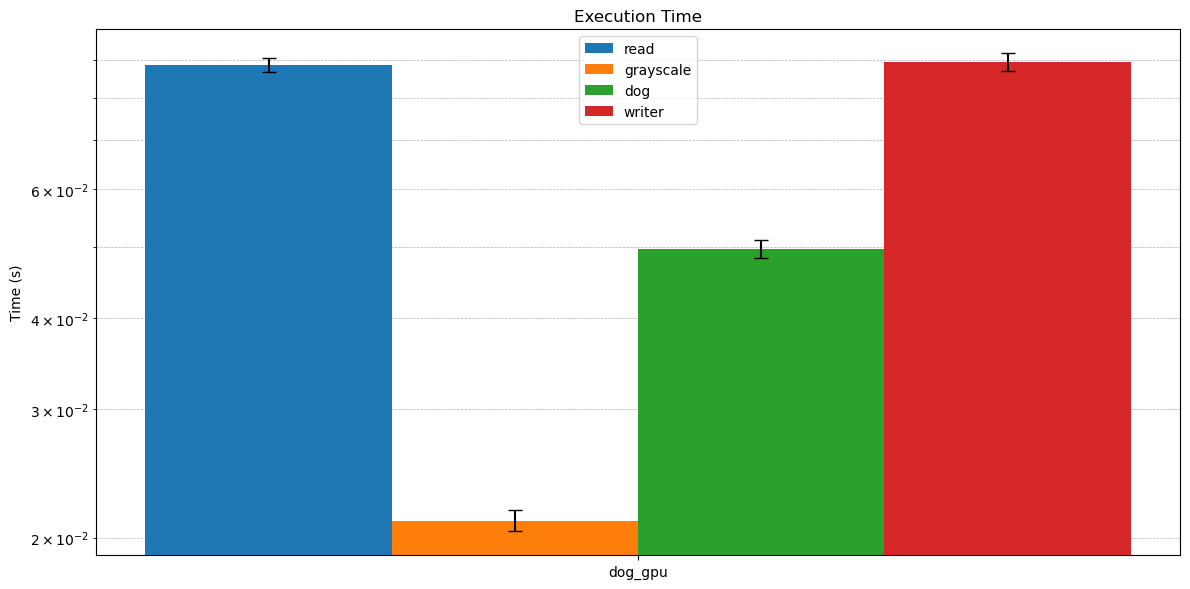

Plot exported as execution_time_plot.pdf


In [20]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())
categories = ['read', 'grayscale', 'dog', 'writer', 'total'][:-1]  # Exclude 'total' for individual bar plots

# Reorder bins for plotting
bins = ['dog', 'dog_optimized', 'dog_parallel', 'dog_gpu']
bins = ['dog_gpu']

# Prepare data for means and confidence intervals
means = {category: [results[bin]['means'][category] for bin in bins] for category in categories}
std_devs = {category: [results[bin]['std_deviation'][category] for bin in bins] for category in categories}

print(means)
print(std_devs)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each category
for i, category in enumerate(categories):
    ax.bar(x + i * width, means[category], width, label=category, yerr=std_devs[category], capsize=5)

# Add labels, title, and legend
#ax.set_xlabel('Bins')
ax.set_ylabel('Time (s)')
ax.set_title('Execution Time')
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels(bins)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

ax.legend()

# Show plot
plt.tight_layout()
plt.show()

# Export the plot as a PDF
with PdfPages('/tmp/execution_time_plot.pdf') as pdf:
    pdf.savefig(fig)
    print("Plot exported as execution_time_plot.pdf")



In [52]:
# stats for dog_parallel

results_parallel = {}

bin_path = 'dog_parallel'
for threads in range(1, 20):
    print(f"Running {bin_path}...")
    stat_sums = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}
    stat_squares = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}

    for i in range(REPETITIONS):
        read, grayscale, dog, writer, total = get_stats(bin_path, threads)
        if total:
            stat_sums['read'] += float(read)
            stat_sums['grayscale'] += float(grayscale)
            stat_sums['dog'] += float(dog)
            stat_sums['writer'] += float(writer)
            stat_sums['total'] += float(total)

            stat_squares['read'] += float(read) ** 2
            stat_squares['grayscale'] += float(grayscale) ** 2
            stat_squares['dog'] += float(dog) ** 2
            stat_squares['writer'] += float(writer) ** 2
            stat_squares['total'] += float(total) ** 2

            print(f"Iteration {i + 1} for {bin_path}, threads {threads}: read: {read}, grayscale: {grayscale}, dog: {dog}, writer: {writer}, total: {total}")

    variances = {
        stat: (stat_squares[stat] / REPETITIONS) - (stat_sums[stat] / REPETITIONS) ** 2
        for stat in stat_sums
    }
    std_deviation = {
        stat: variances[stat] ** 0.5
        for stat in variances
    }
    means = {
        stat: stat_sums[stat] / REPETITIONS
        for stat in stat_sums
    }

    results_parallel[threads] = {
        'means': means,
        'variances': variances,
        'std_deviation': std_deviation
    }
    
    print(f"Results for {bin_path}:")
    for stat in means:
        print(f"  {stat}: {means[stat]} ± {std_deviation[stat]} (variance: {variances[stat]})")


Running dog_parallel...
Iteration 1 for dog_parallel, threads 1: read: 0.150536, grayscale: 0.030389, dog: 26.756231, writer: 0.380809, total: 27.317965
Iteration 2 for dog_parallel, threads 1: read: 0.148910, grayscale: 0.031000, dog: 26.741940, writer: 0.375387, total: 27.297238
Iteration 3 for dog_parallel, threads 1: read: 0.147282, grayscale: 0.031603, dog: 26.817681, writer: 0.374300, total: 27.370866
Results for dog_parallel:
  read: 0.14890933333333334 ± 0.0013284400208093596 (variance: 1.7647528888879715e-06)
  grayscale: 0.03099733333333333 ± 0.0004956170116353159 (variance: 2.4563622222232087e-07)
  dog: 26.77195066666667 ± 0.03285833947964092 (variance: 0.0010796704733593288)
  writer: 0.37683200000000006 ± 0.0028469620065376088 (variance: 8.105192666668648e-06)
  total: 27.328689666666666 ± 0.031000370453054968 (variance: 0.0009610229682266436)
Running dog_parallel...
Iteration 1 for dog_parallel, threads 2: read: 0.149014, grayscale: 0.031112, dog: 14.317738, writer: 0.37

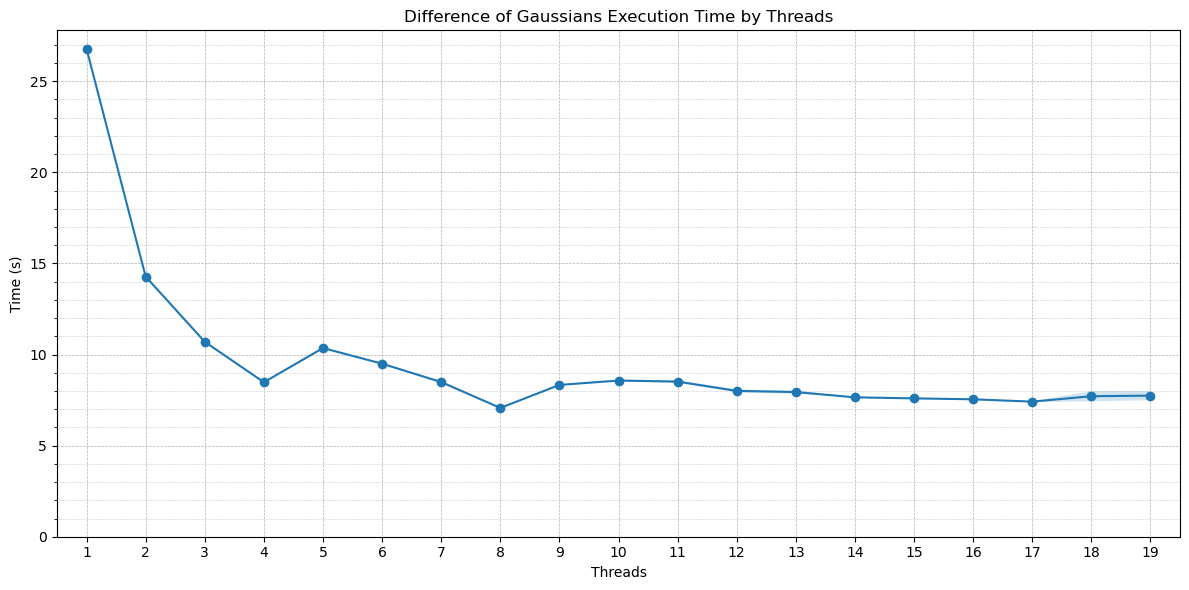

In [79]:
# Extract data for plotting
threads = list(results_parallel.keys())
categories = ['dog']

# Prepare data for means and confidence intervals
means_parallel = {category: [results_parallel[t]['means'][category] for t in threads] for category in categories}
std_devs_parallel = {category: [results_parallel[t]['std_deviation'][category] for t in threads] for category in categories}

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for category in categories:
    mean_values = means_parallel[category]
    std_values = std_devs_parallel[category]
    ax.plot(threads, mean_values, label=category)
    ax.fill_between(threads, 
                    [m - s for m, s in zip(mean_values, std_values)], 
                    [m + s for m, s in zip(mean_values, std_values)], 
                    alpha=0.2)

# Remove minor ticks for x-axis
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.minorticks_on()
ax.xaxis.grid(False, which='minor')
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
#ax.set_xticks(threads)
#ax.set_xticks([t + 0.5 for t in threads[:-1]], minor=True)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0.5, right=max(threads) + 0.5)
ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
ax.set_xticks(threads)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
ax.scatter(threads, mean_values, color=ax.lines[-1].get_color(), zorder=5)
ax.set_xlabel('Threads')
ax.set_ylabel('Time (s)')
ax.set_title('Difference of Gaussians Execution Time by Threads')
#ax.set_yscale('log')
#ax.legend()

# Show plot
plt.tight_layout()
plt.show()